# Mixture Project Data Analysis

This notebook performs the data analysis for the mixture project paper. The purpose of this notebook is to demonstrate that ML models can be used to predict solution concentrations from spectra of the mixtures. The performance of various ML models are compared under different conditions. 

## Import Required Packages

### Import tensorflow

In [ ]:
%tensorflow_version 2.x
import tensorflow
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install optuna

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt 
import numpy as np
import typing
from typing import Tuple, Iterable, List, Dict, Optional, Callable
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy import sparse
from scipy.sparse.linalg import spsolve 
from os.path import join
import pandas as pd
import sklearn.metrics as metrics
from collections import OrderedDict 
from itertools import count
from itertools import cycle
import glob
from pathlib import Path, PurePath
from dataclasses import dataclass
import json
from sklearn.model_selection import train_test_split
import re 
import keras
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

## Define Helper Functions

### Define Visualization Helper Functions

In [ ]:
def plot_comparison_graphs(class_names, y_actual, y_pred, title='', color='teal'):
    fig, axes = plt.subplots(5,1,figsize=(5,20))
    #fig.delaxes(axes.flatten()[-1])
    for class_name, ax, class_index in zip(class_names, axes.flatten(), count()):
        ax.plot(y_actual[:,class_index],y_pred[:,class_index], 'o' ,alpha =0.5,color=color)
        ax.plot([-0.1,1.1],[-0.1,1.1],linewidth=2,linestyle='--',color='k')
        ax.set_xlim((0,1))
        ax.set_ylim((0,1))
        ax.set_title(class_name)
        ax.set_xlabel("Actual Value")
        ax.set_ylabel("Predicted Value")
    
    fig.suptitle(title,fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.savefig('/content/drive/Shareddrives/MixtureProject/compare_graph_' + str(title) + '.svg')

    #fig.tight_layout(rect=[0, 0.03, 1, 0.95])


In [ ]:
def plot_comparison_graphs_together(class_names, method_names, y_actual, y_pred_list, color_iter, title=''):

    fig, axes = plt.subplots(2,3,figsize=(10,6))
    fig.tight_layout(pad=3.0)
    fig.delaxes(axes.flatten()[-1])
    
    for y_pred, color, method_name in zip(y_pred_list, color_iter, method_names):
        for class_name, ax, class_index in zip(class_names, axes.flatten(), count()):
            ax.plot(y_actual[:,class_index],y_pred[:,class_index], 'o' ,alpha =0.5, label=method_name,color=color)
            ax.plot([-0.1,1.1],[-0.1,1.1],linewidth=2,linestyle='--',color='k')
            ax.set_xlim((0,1))
            ax.set_ylim((0,1))
            ax.set_title(class_name)
            ax.set_xlabel("Actual Value")
            ax.set_ylabel("Predicted Value")

    plt.savefig('/content/drive/Shareddrives/MixtureProject/compare_graph_together.svg')
    #h, l = axes.flatten()[-2].get_legend_handles_labels() 
    #axes.flatten()[-1].legend(h,1)
    #fig.suptitle(title,fontsize=16)


### Define Helper Classes

In [ ]:
wavenumbers = None # define wavenumbers here 

In [ ]:
@dataclass
class SpectrumDataset:
  key: str
  folder_path: str
  X: Optional[np.array] = None
  y: Optional[np.array] = None
  species_indices: Optional[Dict[str, int]] = None 
  X_train: Optional[np.array] = None
  y_train: Optional[np.array] = None
  X_test: Optional[np.array] = None
  y_test: Optional[np.array] = None

  def build_dataset(self):
    self.X = np.load(PurePath(self.folder_path, 'X.npy'))
    self.y = np.load(PurePath(self.folder_path, 'y.npy'))
    with open(PurePath(self.folder_path, 'species_indices.json'), 'r') as f:
        self.species_indices = json.load(f)
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        self.X, self.y, test_size=0.30, random_state=42)
  
  def delete_dataset(self):
    del self.X
    del self.y
    del self.X_train
    del self.y_train
    del self.X_test
    del self.y_test
    
  @property
  def size(self):
      size_search = re.search(r'(size_)([0-9]+)', self.key)
      return int(size_search.group(2))
  
  @property
  def wn_std(self):
      wn_search = re.search(r'(wn_std_)([0-9.]+)', self.key)
      return float(wn_search.group(2))
  
  @property
  def amp_std(self):
      result = re.search(r'(amp_std_)([0-9.]+)', self.key)
      return float(result.group(2))

  @property
  def width_std(self):
      result = re.search(r'(width_std_)([0-9.]+)', self.key)
      return float(result.group(2))
  
  @property
  def add_baseline(self):
      result = re.search(r'(add_baseline_)([A-z]+)', self.key)
      return result.group(2) == 'True'



In [ ]:
class SpectraRegModel:
  def __init__(self, dataset: SpectrumDataset, model_name: str, 
               hyperparamter_tuner: Callable):
    self.metric = 'neg_mean_squared_error'
    self.dataset = dataset
    self.model_name = model_name
    self.hyperparamter_tuner = hyperparamter_tuner 
    self.trained_model = None
    self.optimal_hyperparams = None
    self.train_error = None
    self.test_error = None
    self.explained_var = None
    self.r2 = None 

  def find_optimal_hyperparameters(self):
    self.dataset.build_dataset()
    self.trained_model = self.hyperparamter_tuner(self)

        
  def train_model(self):
    if 'PLS' in self.model_name:
      self.trained_model.fit(self.X_train, self.y_train)
    else:
      self.trained_model.fit(self.X_train, self.y_train, epochs=20)
    y_train_pred = self.trained_model.predict(self.X_train)
    try:
        self.train_error = mean_squared_error(self.y_train, y_train_pred)
    except ValueError:  # if there are nans in y_train_pred set inf error 
        self.train_error = float('inf')

    return self.train_error    

  def get_test_error(self):
    if self.test_error:
      return self.test_error 
    
    y_test_pred = self.trained_model.predict(self.X_test)
    try:
        self.test_error = mean_squared_error(self.y_test, y_test_pred)
    except ValueError:  # if there are nans in y_test_pred set inf error
        self.test_error = float('inf')
    
    return self.test_error 

  
  def get_explained_variance(self):
    if self.explained_var:
      return self.explained_var 
    
    y_test_pred = self.trained_model.predict(self.X_test)
    try:
        self.explained_var = explained_variance_score(self.y_test, y_test_pred)
    except ValueError:  # if there are nans in y_test_pred set inf error
        self.explained_var = 0
    
    return self.explained_var 
  
  def get_r2(self):
    if self.r2:
      return self.r2
    
    y_test_pred = self.trained_model.predict(self.X_test)
    
    try:
      self.r2 = r2_score(self.y_test, y_test_pred)
    except ValueError:  # if there are nans in y_test_pred set inf error
      self.r2 = 0
    
    return self.r2 

  @property
  def key(self):
    return self.dataset.key
  
  @property  # CNN require different data input shapes
  def X_train(self):
    W_train = self.dataset.X_train #(self.dataset.X_train - np.mean(self.dataset.X_train, axis=0))/np.std(self.dataset.X_train, axis=0)
    if ('resnet' not in self.model_name) and ('simpleCNN' not in self.model_name):
      return self.dataset.X_train
    else:
      return np.reshape(self.dataset.X_train,
                        (self.dataset.X_train.shape[0], 
                         self.dataset.X_train.shape[1], 1))

  @property
  def X_test(self):
    W_test = self.dataset.X_test #(self.dataset.X_test - np.mean(self.dataset.X_train, axis=0))/np.std(self.dataset.X_train, axis=0)
    if ('resnet' not in self.model_name) and ('simpleCNN' not in self.model_name) :
      return W_test
    else:
      return np.reshape(W_test,
                        (self.dataset.X_test.shape[0], 
                         self.dataset.X_test.shape[1], 1))

  @property
  def y_train(self):
    return (self.dataset.y_train - np.mean(self.dataset.y_train, axis=0))/np.std(self.dataset.y_train, axis=0)

  @property
  def y_test(self):
    return (self.dataset.y_test - np.mean(self.dataset.y_train, axis=0))/np.std(self.dataset.y_train, axis=0)

```python

X_train= X_spectra_train #-np.mean(X_spectra_train,axis=0))/np.std(X_spectra_train, axis=0)
w_train = (y_train- np.mean(y_train,axis=0))/np.std(y_train, axis=0)

X_val =  X_spectra_val  #- np.mean(X_spectra_val,axis=0))/np.std(X_spectra_val, axis=0)
w_val = (y_val- np.mean(y_val,axis=0))/np.std(y_val, axis=0)

## Load Data

### Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Get Data Folder Paths and Create folder_path Object

In [ ]:
folder_paths = glob.glob("/content/drive/Shareddrives/MixtureProject/gen_data_3/*")

In [ ]:
data_dict: Dict[str, SpectrumDataset] = {}
for folder_path in folder_paths:
    key = Path(folder_path).name
    data_dict[key] = SpectrumDataset(key, folder_path)

In [ ]:
len(folder_paths)

48

### Define Data Shape

In [ ]:
data_dict[key].build_dataset()
Y_DATA_SHAPE = data_dict[key].y.shape[1]
X_DATA_SHAPE = data_dict[key].X.shape[1]

## Define Models

This section defines the models used in the system. The hyperpamter tuning model returns a compiled model with the optimal parameters. 

#### PLS Regression

In [ ]:
from sklearn.cross_decomposition import PLSRegression

In [ ]:
def get_PLS_regressor(n_components):
  return PLSRegression(n_components=n_components)

In [ ]:
def PLS_hyperparameter_tuner(model :SpectraRegModel):
  return get_PLS_regressor(n_components=10)
    # def objective(trial):
    #   n_components = trial.suggest_int("n_components", 2, 100)
    #   pls_reg = get_PLS_regressor(n_components=n_components)
    #   # X_train = np.reshape(model.dataset.X_train, (model.dataset.X_train.shape[0],
    #   #                                              model.dataset.X_train.shape[1]))
    #   scores = cross_val_score(pls_reg, model.X_train,
    #                            model.dataset.y_train, cv=3,
    #                            scoring=model.metric)
    #   #  print(model.dataset.X_train,
    #   #        model.dataset.y_train,
    #   #        model.metric)
    #   #print(model.metric)
    #   return -1*scores.mean()

    # study = optuna.create_study()
    # study.optimize(objective, n_trials=1)
    
    # while True: 
    #   try:
    #     return get_PLS_regressor(**study.best_params)
    #   except ValueError:
    #     pass


### Simple NN

In [ ]:
def get_simple_NN(learning_rate):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(units=X_DATA_SHAPE, activation='relu', input_shape=(X_DATA_SHAPE,)),
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
      tf.keras.layers.Dense(Y_DATA_SHAPE,activation='linear')
  ])
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  nn_model.compile(optimizer='adam',
                loss = tf.keras.losses.MSE,
                metrics=['mean_squared_error'])
  return nn_model

In [ ]:
def simple_nn_hyperparameter_tuner(model: SpectraRegModel):
    return get_simple_NN(0.001)
    # def objective(trial):
    #   # define parameters to vary 
    #   learning_rate = trial.suggest_float("learning_rate", 0.001, 1)
    #   nn_model = get_simple_NN(learning_rate)
    #   scores = cross_val_score(nn_model, model.dataset.X_train,
    #                            model.dataset.y_train, cv=5,
    #                            scoring=model.metric)
    #   return -1*scores.mean()

    # study = optuna.create_study()
    # study.optimize(objective, n_trials=10)

    # while True: 
    #   try:
    #     return get_simple_NN(**study.best_params)
    #   except ValueError:
    #     pass

#### Simple CNN

In [ ]:
# define convolution neural network model 
def get_simple_CNN(learning_rate):
  cnn_model = tf.keras.Sequential([
      tf.keras.layers.Conv1D(20, 5,activation='relu',input_shape=(X_DATA_SHAPE,1)),
      tf.keras.layers.MaxPooling1D(pool_size=5),
      tf.keras.layers.Conv1D(20, 3,activation='relu',input_shape=(X_DATA_SHAPE,1)),
      tf.keras.layers.MaxPooling1D(pool_size=3),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=128),
      tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
      tf.keras.layers.Dense(Y_DATA_SHAPE,activation='linear')
  ])
  cnn_model.compile(optimizer='adam',
                loss = tf.keras.losses.MSE,
                metrics=['mean_squared_error'])
  return cnn_model


In [ ]:
def simple_cnn_hyperparameter_tuner(model: SpectraRegModel):
    return get_simple_CNN(0.01)
    # def objective(trial):
    #   # define parameters to vary 
    #   learning_rate = trial.suggest_float("learning_rate", 0.001, 1)
    #   cnn_model = get_simple_CNN(learning_rate)
    #   scores = cross_val_score(cnn_model, model.dataset.X_train,
    #                            model.dataset.y_train, cv=5,
    #                            scoring=model.metric)
    #   return -1*scores.mean()

    # study = optuna.create_study()
    # study.optimize(objective, n_trials=10)
    # while True: 
    #   try:
    #     return get_simple_CNN(**study.best_params)
    #   except ValueError:
    #     pass

    # return get_simple_CNN(**study.best_params)


### ResNet

In [ ]:
from functools import partial

DefaultConv1D = partial(keras.layers.Conv1D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv1D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv1D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv1D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)


def get_resnet(learning_rate):
  DefaultConv1D = partial(keras.layers.Conv1D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

  model = keras.models.Sequential()
  model.add(DefaultConv1D(64, kernel_size=7, strides=2,
                          input_shape=(X_DATA_SHAPE,1)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation("relu"))
  model.add(keras.layers.MaxPool1D(pool_size=3, strides=2, padding="SAME"))
  prev_filters = 64
  for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
      strides = 1 if filters == prev_filters else 2
      model.add(ResidualUnit(filters, strides=strides))
      prev_filters = filters
  model.add(keras.layers.GlobalAvgPool1D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(Y_DATA_SHAPE,activation='linear'))
  model.compile(optimizer='adam',
                loss = tf.keras.losses.MSE,
                metrics=['mean_squared_error'])
  return model 



In [ ]:
def resnet_hyperparameter_tuner(model: SpectraRegModel):
    return get_resnet(0.01)
    # def objective(trial):
    #   # define parameters to vary 
    #   learning_rate = trial.suggest_float("learning_rate", 0.001, 1)
    #   resnet_model = get_resnet(learning_rate)
    #   scores = cross_val_score(resnet_model, model.dataset.X_train,
    #                            model.dataset.y_train, cv=5,
    #                            scoring=model.metric)
    #   return -1*scores.mean()

    # study = optuna.create_study()
    # study.optimize(objective, n_trials=10)
     
    # while True: 
    #   try:
    #     return get_resnet(**study.best_params)
    #   except ValueError:
    #     pass



## Build Spectra Reg Models 

In this section the SPectraRegModel objects are created, trained and tested

### Build Modles

In [ ]:
spec_models = {}
for key, ds in data_dict.items():
  model_dict = {}
  model1 = 'PLS'
  model_dict[model1] = SpectraRegModel(ds,model1, PLS_hyperparameter_tuner)
  model2 = 'simpleNN'
  model_dict[model2] = SpectraRegModel(ds, model2, simple_nn_hyperparameter_tuner)
  model3 = 'simpleCNN'
  model_dict[model3] = SpectraRegModel(ds, model3, simple_cnn_hyperparameter_tuner)
  model4 = 'resnet'
  model_dict[model4] = SpectraRegModel(ds, model4, resnet_hyperparameter_tuner)  
  spec_models[key] = model_dict

### Train and Test Models

In [ ]:
# create dataframe to store results 
df = pd.DataFrame()

In [ ]:
for key, model_dict in spec_models.items():
  for model_name, model in model_dict.items():
    print(f'Attempting model key {key} with model {model_name}')
    model.find_optimal_hyperparameters()
    model.train_model()
    score = model.get_test_error()
    explained_var = model.get_explained_variance()
    r2 = model.get_r2()
    df = df.append({'key': key,
                'model': model_name,
                'score': score,
                'explained_var': explained_var, 
                'r2': r2,
                'size': model.dataset.size,
                'noise': model.dataset.wn_std,
                'add_baseline': model.dataset.add_baseline}, ignore_index=True)
    dataset = model.dataset
    #del model
    print('score is', score, 'r2 is', r2)
  
  #dataset.delete_dataset()
  

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 18/20
1/1 [==============================] - 0s 34ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 19/20
1/1 [==============================] - 0s 34ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 20/20
1/1 [==============================] - 0s 36ms/step - loss: 0.0052 - mean_squared_error: 0.0052
score is 1209639.6951247263 r2 is -1318554.0939655942
Attempting model key size_10_wn_std_0.5_amp_std_0.5_width_std_0.5_add_baseline_True with model PLS
score is 1.1971202112531167 r2 is -0.9534186082052514
Attempting model key size_10_wn_std_0.5_amp_std_0.5_width_std_0.5_add_baseline_True with model simpleNN
Epoch 1/20
1/1 [==============================] - 0s 303ms/step - loss: 808.7814 - mean_squared_error: 808.7814
Epoch 2/20
1/1 [==============================] - 0s 5ms/step - loss: 144403.0469 - mean_squared_error: 14

## Data Analysis

The models have been trained and fit. The next step is comparing their performance. This is achieved by using a Pandas Dataframe to organize the results of the fitting

In [ ]:
out = '/content/drive/Shareddrives/MixtureProject/output.csv'
df.to_csv(out, index=False)
df.head()

,add_baseline,explained_var,key,model,noise,r2,score,size
0,0.0,0.080209,size_10_wn_std_1.0_amp_std_1.0_width_std_1.0_a...,PLS,1.0,-5.733120e+00,1.733606e+00,10.0
1,0.0,-81.146410,size_10_wn_std_1.0_amp_std_1.0_width_std_1.0_a...,simpleNN,1.0,-5.205169e+02,2.044858e+02,10.0
2,0.0,-11.625333,size_10_wn_std_1.0_amp_std_1.0_width_std_1.0_a...,simpleCNN,1.0,-3.555158e+01,2.499148e+01,10.0
3,0.0,-44143.358175,size_10_wn_std_1.0_amp_std_1.0_width_std_1.0_a...,resnet,1.0,-5.820655e+06,6.127739e+06,10.0
4,0.0,-4.009971,size_10_wn_std_1.5_amp_std_1.5_width_std_1.5_a...,PLS,1.5,-7.748624e+00,2.415240e+00,10.0


In [ ]:
# get models, unique baseslines, sizes and noises 
models = df['model'].unique()
add_baseline = df['add_baseline'].unique()
add_baseline.sort()
sizes = df['size'].unique()
sizes.sort()
noises = df['noise'].unique()
noises.sort()
display('models', models, 'add_baseline', add_baseline, 'sizes', sizes, 'noises', noises)

'models'

array(['PLS', 'simpleNN', 'simpleCNN', 'resnet'], dtype=object)

'add_baseline'

array([0., 1.])

'sizes'

array([   10.,   100.,  1000., 10000.])

'noises'

array([0. , 0.1, 0.5, 1. , 1.5, 2. ])

### Find the best performing model for each dataset

In [ ]:
# find the best performing models for a certain dataset 
idx = df.groupby(by='key')['explained_var'].transform(max) == df['explained_var']
best_models = df[idx]
best_models.head(30)

,add_baseline,explained_var,key,model,noise,r2,score,size
0,0.0,0.080209,size_10_wn_std_1.0_amp_std_1.0_width_std_1.0_a...,PLS,1.0,-5.733120,1.733606e+00,10.0
4,0.0,-4.009971,size_10_wn_std_1.5_amp_std_1.5_width_std_1.5_a...,PLS,1.5,-7.748624,2.415240e+00,10.0
8,0.0,-0.892998,size_10_wn_std_0.5_amp_std_0.5_width_std_0.5_a...,PLS,0.5,-1.283925,3.066485e+00,10.0
12,1.0,-0.224666,size_10_wn_std_1.5_amp_std_1.5_width_std_1.5_a...,PLS,1.5,-1.087241,3.009847e+00,10.0
16,0.0,0.651820,size_10_wn_std_0.1_amp_std_0.1_width_std_0.1_a...,PLS,0.1,-0.348570,1.181447e-01,10.0
20,1.0,-0.711744,size_10_wn_std_1.0_amp_std_1.0_width_std_1.0_a...,PLS,1.0,-3.808130,2.968655e+00,10.0
24,1.0,0.765510,size_10_wn_std_0.1_amp_std_0.1_width_std_0.1_a...,PLS,0.1,0.368692,2.147393e-01,10.0
28,0.0,1.000000,size_10_wn_std_0_amp_std_0_width_std_0_add_bas...,PLS,0.0,1.000000,8.834754e-31,10.0
32,1.0,0.895362,size_10_wn_std_0_amp_std_0_width_std_0_add_bas...,PLS,0.0,0.875375,1.214799e-01,10.0
36,1.0,-0.085634,size_10_wn_std_0.5_amp_std_0.5_width_std_0.5_a...,PLS,0.5,-0.953419,1.197120e+00,10.0


In [ ]:
with_baseline_size_noise_dict = OrderedDict()
without_baseline_size_noise_dict = OrderedDict()
for baseline in [True, False]:
    if baseline:
        size_noise_dict = with_baseline_size_noise_dict
    else:
        size_noise_dict = without_baseline_size_noise_dict
    
    for size in sizes:
        size_noise_dict[size] = {}
        for noise in noises:
            try:
                size_noise_dict[size][noise] = best_models[(best_models["size"]==size)*(best_models["noise"]==noise)*(best_models["add_baseline"]==baseline)].iloc[0]['model']
            except IndexError:
                size_noise_dict[size][noise] = 'None'
         

In [ ]:
model_list = list(models)
model_list.append('None')

In [ ]:
# build color map between models and color 
color_mapping = OrderedDict()
color_pallette = sns.color_palette("hls", len(model_list))
for model_name, color in zip(model_list, color_pallette):
  color_mapping[model_name] = color

In [ ]:
# create a function that makes a matrix to plot 
def make_color_matrix(size_noise_dict: OrderedDict, color_mapping: Dict):
  max_length = max([len(v) for v in size_noise_dict.values()])
  color_matrix = np.zeros((len(size_noise_dict), max_length, 3))
  for i, size in enumerate(size_noise_dict):
    for j, noise in enumerate(size_noise_dict[size]):
      value = size_noise_dict[size][noise]
      color_matrix[i][j][:] = color_mapping[value]
  return color_matrix

In [ ]:
color_matrix_with_baseline = make_color_matrix(with_baseline_size_noise_dict, color_mapping)

In [ ]:
color_matrix_no_baseline = make_color_matrix(without_baseline_size_noise_dict, color_mapping)

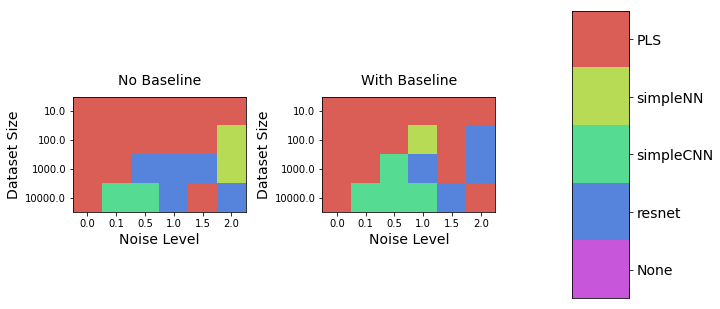

In [ ]:
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(nrows=1, ncols=3, width_ratios=[3,3,1])
#ax0
ax0 = fig.add_subplot(gs[0,0])
ax0.set_title('No Baseline', fontsize=14)
ax0.set_xlabel('Noise Level', fontsize=14)
ax0.set_ylabel('Dataset Size', fontsize=14)

cax = ax0.matshow(color_matrix_with_baseline)
xaxis = np.arange(len(noises))
ax0.set_xticks(xaxis)
ax0.set_xticklabels(noises)
yaxis = np.arange(len(sizes))
ax0.set_yticks(yaxis)
ax0.set_yticklabels(sizes)
ax0.xaxis.tick_bottom()
#ax1 
ax1 = fig.add_subplot(gs[0,1])
ax1.set_xlabel('Noise Level', fontsize=14)
ax1.set_ylabel('Dataset Size', fontsize=14)

cax = ax1.matshow(color_matrix_no_baseline)
xaxis = np.arange(len(noises))
ax1.set_xticks(xaxis)
ax1.set_xticklabels(noises)
yaxis = np.arange(len(sizes))
ax1.set_yticks(yaxis)
ax1.set_yticklabels(sizes)
ax1.xaxis.tick_bottom()

#ax1.set_ylabel('Dataset Size', fontsize=14)
ax1.set_title('With Baseline', fontsize=14)
ax2 = fig.add_subplot(gs[0,2])
# plot legend 
ax2.yaxis.tick_right()
names = list(color_mapping.keys())
color_bar = list(color_mapping.values())
color_matrix = np.zeros((len(color_bar), 1, 3))
for index, color in enumerate(color_mapping.values()):
  color_matrix[index][0][:] = color 

cax = ax2.matshow(color_matrix)
xaxis = np.arange(len(color_bar))
ax2.set_yticks(xaxis)
ax2.set_yticklabels(names, fontsize=14)
ax2.set_xticks([])
fig.tight_layout()
plt.savefig('/content/drive/Shareddrives/MixtureProject/performance_graph_1.svg')


### Find each model performance for each dataset


In [ ]:
size_noise_to_indices = {}
for i, size in enumerate(sizes):
  size_noise_to_indices[size] = {}
  for j, noise in enumerate(noises):
    size_noise_to_indices[size][noise] = (i, j)

In [ ]:
size_noise_dict

OrderedDict([(10.0,
              {0.0: 'PLS',
               0.1: 'PLS',
               0.5: 'PLS',
               1.0: 'PLS',
               1.5: 'PLS',
               2.0: 'PLS'}),
             (100.0,
              {0.0: 'PLS',
               0.1: 'PLS',
               0.5: 'PLS',
               1.0: 'simpleNN',
               1.5: 'PLS',
               2.0: 'resnet'}),
             (1000.0,
              {0.0: 'PLS',
               0.1: 'PLS',
               0.5: 'simpleCNN',
               1.0: 'resnet',
               1.5: 'PLS',
               2.0: 'resnet'}),
             (10000.0,
              {0.0: 'PLS',
               0.1: 'simpleCNN',
               0.5: 'simpleCNN',
               1.0: 'simpleCNN',
               1.5: 'resnet',
               2.0: 'PLS'})])

In [ ]:
model_baseline_dict = {}

for add_baseline in [True, False]:
  model_matrix_dict = OrderedDict()
  model_baseline_dict[add_baseline] = model_matrix_dict
  for model in models:
    if model == 'None':
      continue
    model_matrix_dict[model] = np.zeros((len(sizes), len(noises)))
    for size in sizes:
      for noise in noises:
        i, j = size_noise_to_indices[size][noise]
        try:
          model_matrix_dict[model][i][j] = df[(df['noise']==noise)*
                                            (df['size']==size)*
                                            (df['add_baseline']==False)*
                                            (df['model']==model)].iloc[0]['explained_var']
        except IndexError:
          model_matrix_dict[model][i][j] = float('inf')

In [ ]:
import matplotlib

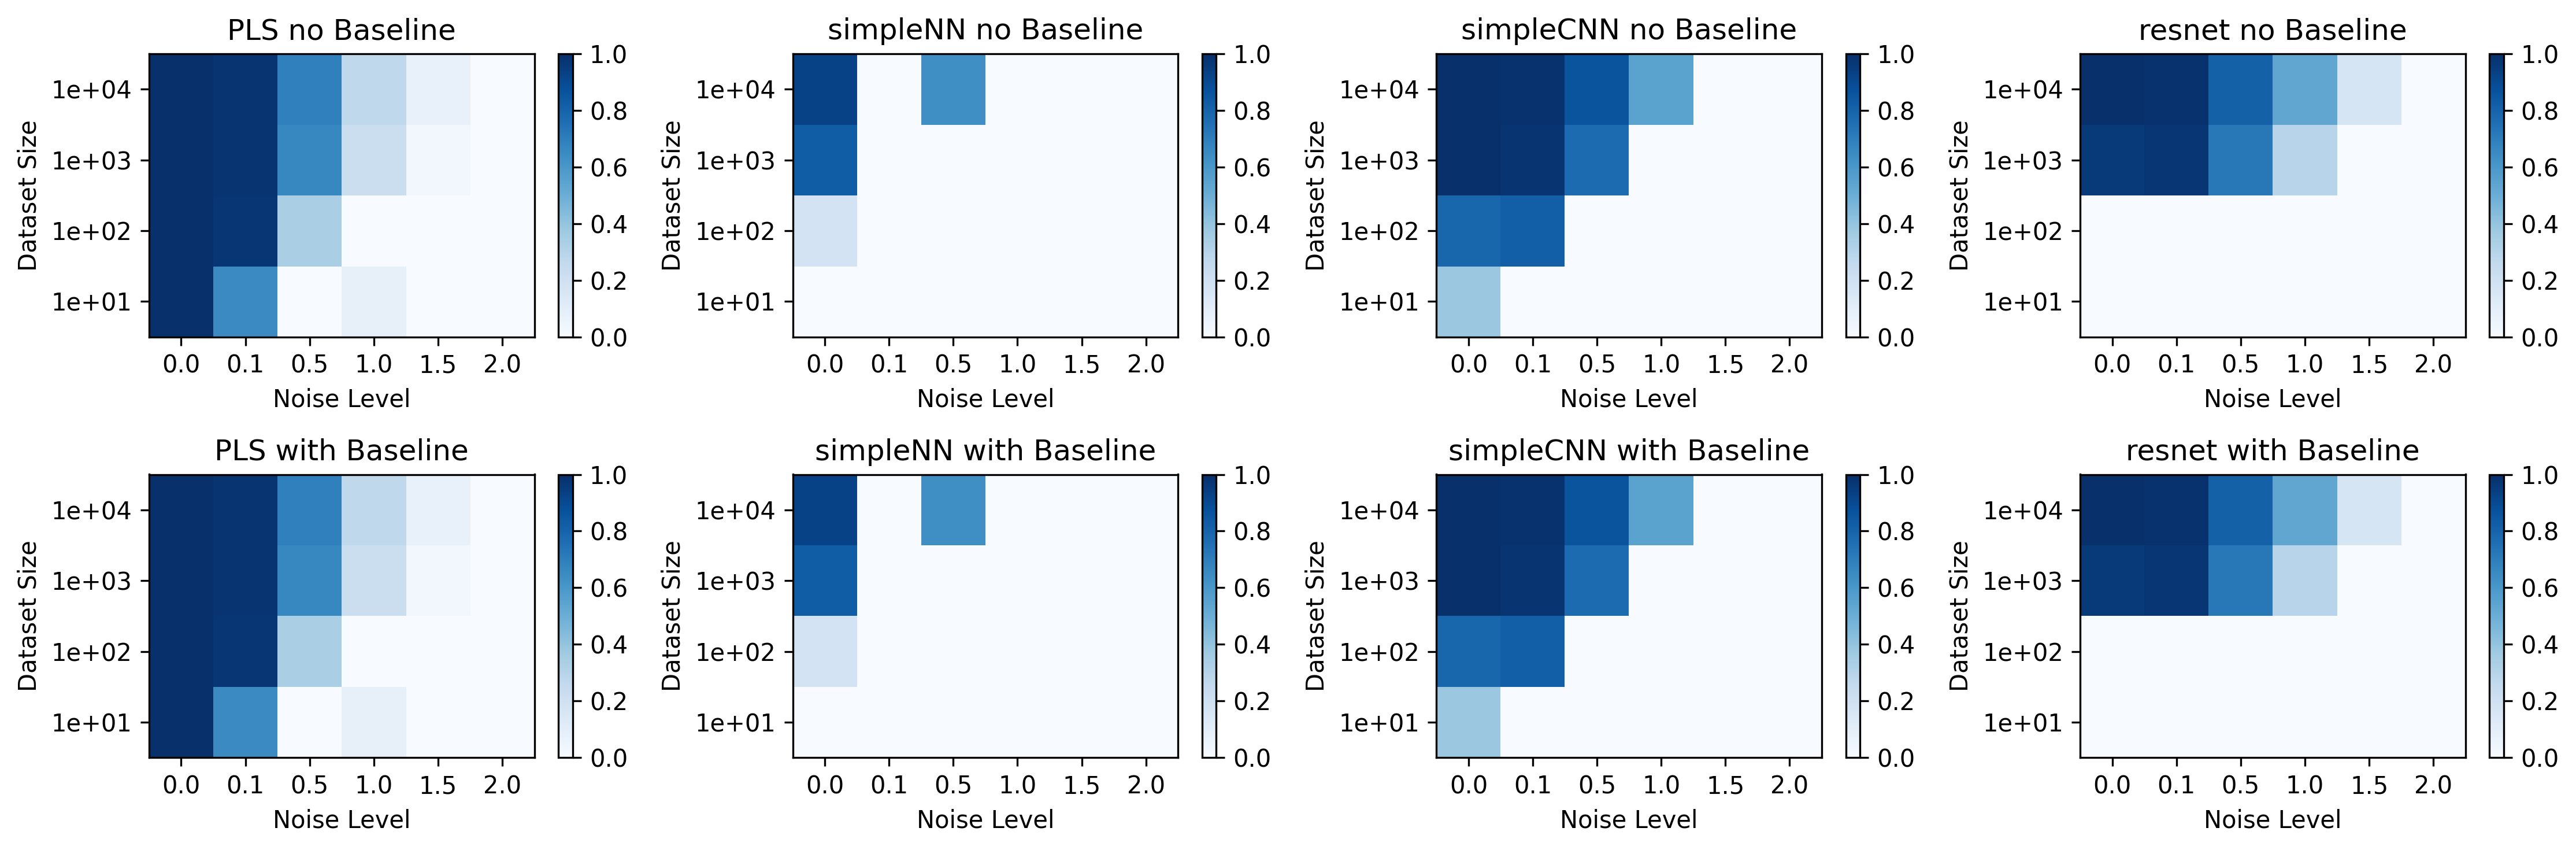

In [ ]:
vmin = 0
vmax = 1e4
fig, axes = plt.subplots(2, 4, figsize=(15,5), dpi=300)
for baseline in [0, 1]:
  model_matrix_dict = model_baseline_dict[baseline]
  for ax, model_name in zip(axes[baseline, :].flatten(), model_matrix_dict):
    xaxis = np.arange(len(noises))
    ax.set_xticks(xaxis)
    ax.set_xticklabels(noises)
    yaxis = np.arange(len(sizes))
    ax.set_yticks(yaxis)
    ax.set_yticklabels(matplotlib.ticker.FormatStrFormatter('%2.0e').format_ticks(sizes))
    ax.xaxis.tick_bottom()
    ax.set_xlabel('Noise Level')
    ax.set_ylabel('Dataset Size')
    if baseline: 
      name = str(model_name) + ' with Baseline'
    else:
      name = str(model_name) + ' no Baseline'
    ax.set_title(name)
    im = ax.imshow(model_matrix_dict[model_name], interpolation='none', 
                  cmap='Blues',origin='lower', aspect="auto")
                  #norm=matplotlib.colors.LogNorm())
    im.set_clim(0,1)
    fig.colorbar(im, ax=ax) 
    
  
fig.tight_layout()
plt.savefig('/content/drive/Shareddrives/MixtureProject/performance_graph.svg')


### Create Plots to see regression error 

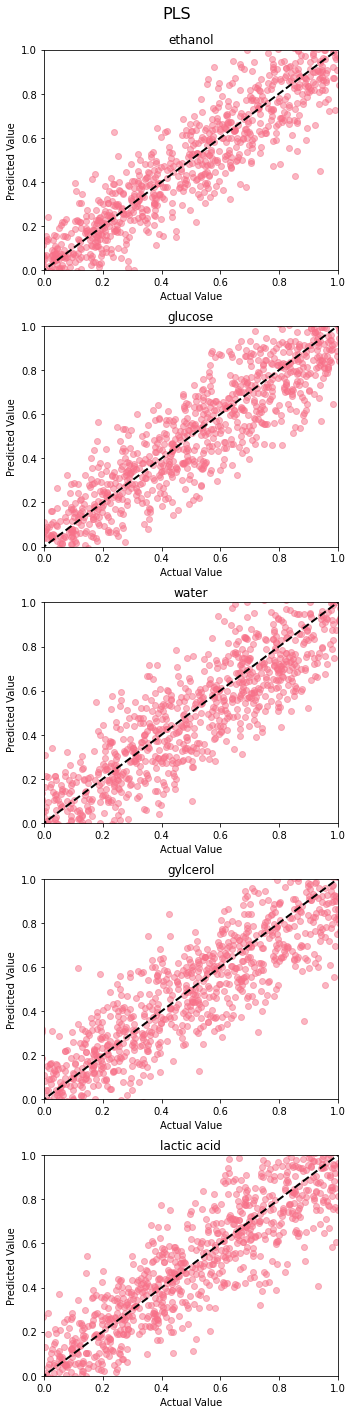

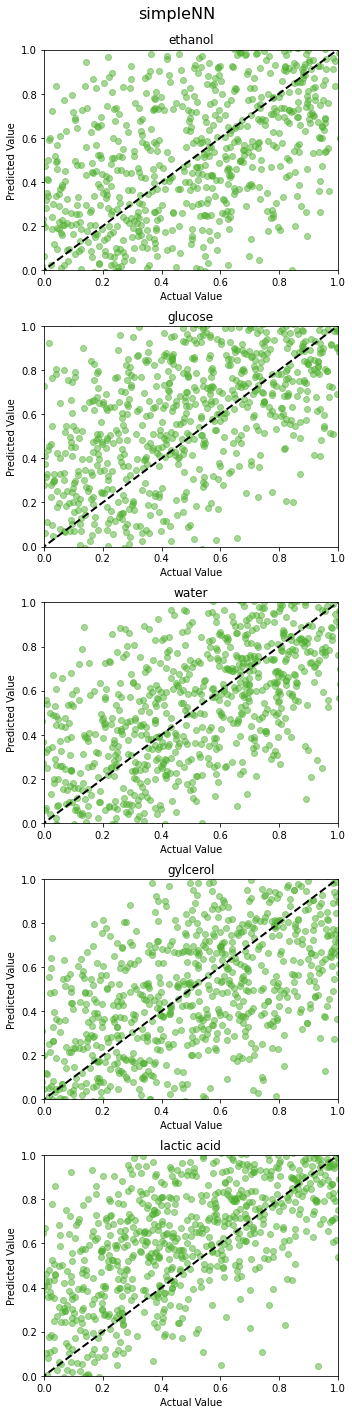

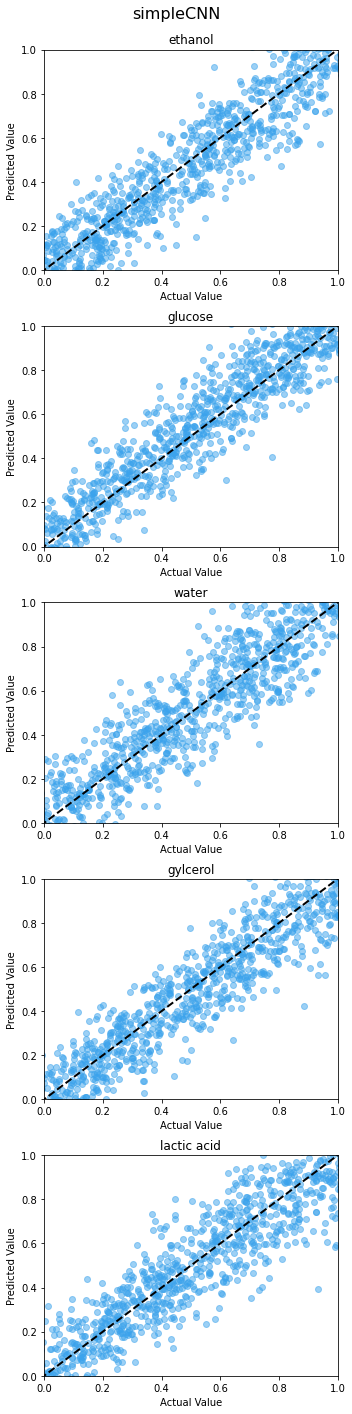

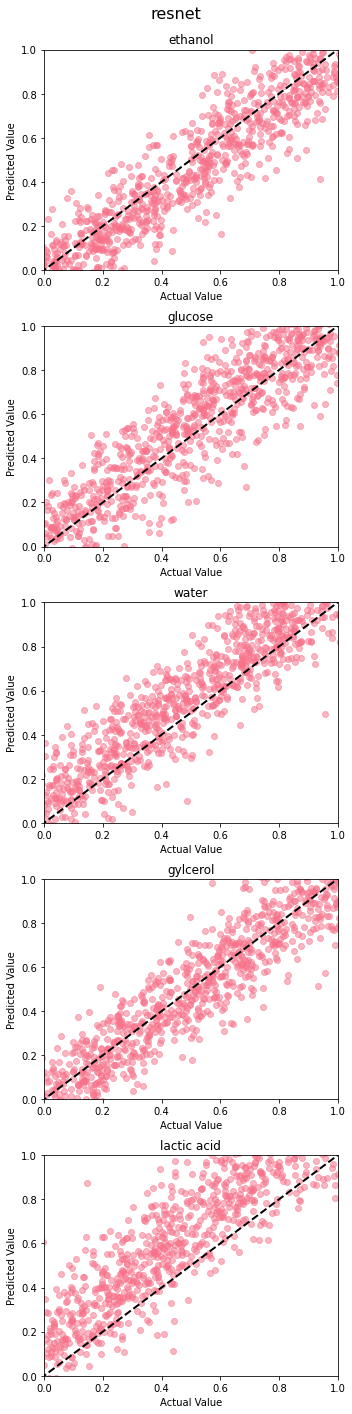

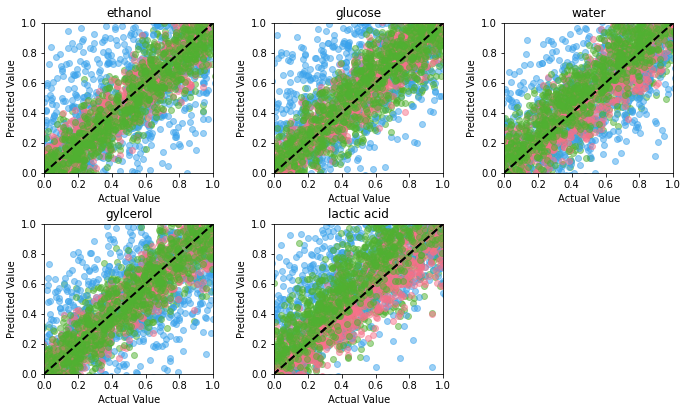

In [ ]:
models = spec_models['size_10000_wn_std_0.1_amp_std_0.1_width_std_0.1_add_baseline_True']
species_indices = {"ethanol": 0, "glucose": 1, "water": 2, "gylcerol": 3, "lactic acid": 4}
color_cycle = cycle([(0.9677975592919913, 0.44127456009157356, 0.5358103155058701), (0.3126890019504329, 0.6928754610296064, 0.1923704830330379), (0.23299120924703914, 0.639586552066035, 0.9260706093977744)])
class_names = list(species_indices.keys())
method_names = []
y_pred_list = []
y_pred_list = []
color_iter = iter(color_cycle)
for model_name, model in models.items():
  method_names.append(model_name)
  y_pred = model.trained_model.predict(model.X_test)
  y_pred_list.append(y_pred)
  y_actual = model.y_test 
  plot_comparison_graphs(class_names, y_actual, y_pred, title=model_name, color=next(color_iter))


plot_comparison_graphs_together(class_names, method_names, y_actual, y_pred_list, color_cycle, title='')


In [ ]:

plot_comparison_graphs_together

In [ ]:
df

In [ ]:

df